# Load Data post feature extraction

In [46]:
# load features
import pickle
features = pickle.load( open( "Onehotfeatures.pkl", "rb" ) )

# load associated targets
from numpy import load
y = load('target.npy')

Choose features and prepare data for scikit-learn prototyping

In [47]:
print([ f[1] for f in features])

['User_ID', 'Product_ID', 'Gender', 'Marital_Status_Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Prod_cat123', 'Gender_Prod_cat123']


In [122]:
# keep features of interest
imp_feature = ['User_ID', 'Product_ID', 'Gender_Prod_cat123']
# imp_feature = ['User_ID', 'Product_ID', 'Gender', 'Prod_cat123']
# only keep corresponding features
X_features = tuple(f[0] for f in features if f[1] in imp_feature)

In [123]:
from scipy.sparse import hstack
X = hstack( X_features )
X.shape, type(X)

((550068, 9993), scipy.sparse.coo.coo_matrix)

# Linear Regression 
Scikit-learn implements the closed-form version: $$ \hat{\theta} = (X^T \cdot X)^{-1} \cdot X^T \cdot y$$ 
Model parameters are optimal (i.e. there is no gradient descent)

In [124]:
from sklearn.linear_model import LinearRegression
# fit_intercept=True adds bias/intercept so that we don't have to worry about it.
# n_jobs doesn't speed up because I only have one target (Purchase)
model = LinearRegression(n_jobs=-1, normalize=False, fit_intercept=True)

Run cross validation on training data

In [125]:
# report score on cross-validation
from sklearn.model_selection import cross_validate, ShuffleSplit

# n_splits is the number of times you split data after shuffling
cv = ShuffleSplit(n_splits=5, test_size=1/5, random_state=4)

# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
cv_results_linear = cross_validate(model, X, y=y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

# plot metrics
import numpy as np
MSE_Xval = -np.mean(cv_results_linear['test_score'])
print('MSE (mean cross-validation) = {:.4f}'.format(MSE_Xval))
print('RMSE (mean cross-validation) = {:.4f}'.format(np.sqrt(MSE_Xval)))

MSE (mean cross-validation) = 6283022.3829
RMSE (mean cross-validation) = 2506.5958


Re-run model on entire training set and get predictions

In [7]:
# train one more time on all instances
model.fit(X,y)

# get predictions
y_pred = model.predict(X)

# plot metrics on training set and compare to cross-validation metrics
from sklearn.metrics import mean_squared_error
print('MSE (whole training set) = {:.4f}'.format(mean_squared_error(y, y_pred)))
print('RMSE (whole training set) = {:.4f}'.format(np.sqrt(mean_squared_error(y, y_pred))))

MSE (whole training set) = 6017192.8707
RMSE (whole training set) = 2452.9967


### Am I overfitting (high variance)? underfitting? (high bias)

There is a gap of about 100 RSME which is small compared to our 2500 RSME of our model but it does indicates our variance is a little elevated. Consider using ridge regularization.

In [ ]:
from sklearn.model_selection import train_test_split
# keep matplotlib interactive
%matplotlib notebook
import matplotlib.pyplot as plt
# use ggplot style
plt.style.use('ggplot')


def plot_learning_curve(model,X,y):
    # split data/target in train and test sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    train_errors, val_errors = [], []
    train_sizes = np.linspace(1, X_train.shape[0], 100, dtype='int64')
    for m in train_sizes:
        # train with m samples
        model.fit(X_train[:m], y_train[:m])
        # predict training data and val data
        y_train_pred = model.predict(X_train[:m])
        y_val_pred = model.predict(X_val)
        # save MSE metric
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        val_errors.append(mean_squared_error(y_val, y_val_pred))
    _ , ax = plt.subplots()
    ax.plot(train_sizes, np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    ax.plot(train_sizes, np.sqrt(val_errors), 'b-', linewidth=2, label='validation')

plot_learning_curve(model,X,y)

### Extreme error analysis (very high error and very low error)

Plot Square error in ascending order to observe error spread. Best and worst examples have the same magnitude! (1e-8 to 1e8 error)

<IPython.core.display.Javascript object>


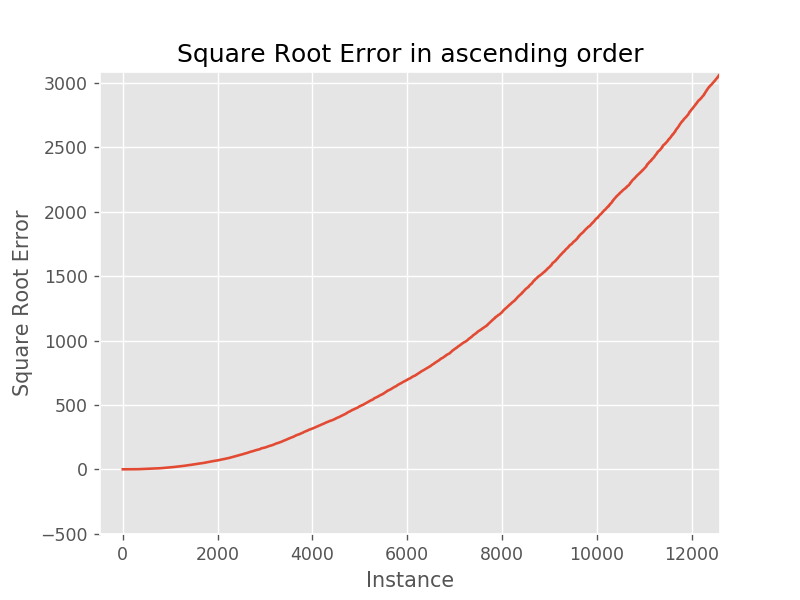

Text(0,0.5,'Square Root Error')

In [80]:
import pandas as pd
# keep matplotlib interactive
%matplotlib notebook
import matplotlib.pyplot as plt
# use ggplot style
plt.style.use('ggplot')

# square error, ascending order
sqerr_asc = np.sort((y-y_pred)**2)

# plot error
_ , axerr = plt.subplots()
axerr.plot(sqerr_asc)
axerr.set_title('Square Error in ascending order')
axerr.set_xlabel('Instance')
axerr.set_ylabel('Square Error per instance')

#### Large Error

In [111]:
# read dataframe post feature extraction
df = pd.read_pickle('DataframeMod.bz2')

# At square_error = 5e7, error rises dramatically
df_worst = df.loc[sqerr_asc > 5e7, :].copy()

# look at a few examples
df_worst.describe(include='all')

Number of worst instances = 7958


,User_ID,Product_ID,Gender,Marital_Status_Age,Occupation,City_Category,Stay_In_Current_City_Years,Prod_cat123,Gender_Prod_cat123,Purchase
count,7.958000e+03,7958,7958,7958,7958.000000,7958,7958,7958,7958,7958.000000
unique,NaN,1554,2,8,NaN,3,2,205,350,NaN
top,NaN,P00371644,M,0-26-35,NaN,C,2+,20-nan-nan,1-128,NaN
freq,NaN,899,5655,1660,NaN,3224,4106,2550,1827,NaN
mean,1.004339e+06,NaN,NaN,NaN,7.871701,NaN,NaN,NaN,NaN,4531.332873
std,1.854019e+03,NaN,NaN,NaN,6.526230,NaN,NaN,NaN,NaN,5642.765670
min,1.000001e+06,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,12.000000
25%,1.002926e+06,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,136.000000
50%,1.005508e+06,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,605.000000
75%,1.005769e+06,NaN,NaN,NaN,14.000000,NaN,NaN,NaN,NaN,7940.000000


In [81]:
def print_rare_cases(Rare):
    Rare_HighErr = df_worst[Rare.name].isin(Rare.index).sum()
    print( 'Number of rare {} having high error = {} out of {} ({:.2f}%)'.format(\
    Rare.name, Rare_HighErr, Rare.count(), Rare_HighErr/Rare.count()*100) )

# Almost None of the rare product ID corresponds to the worst cases
ProdID_distrib = df.Product_ID.value_counts()
RareProdID = ProdID_distrib[ProdID_distrib < 5]
print_rare_cases(RareProdID)

# what about rare users?
# rare user is defined as less than 10-16 occurrence (see distribution of users)
UserID_distrib = df.User_ID.value_counts()
RareUsers = UserID_distrib[UserID_distrib < 16]
print_rare_cases(RareUsers)

# what about Prod cat123?
ProdCat_distrib = df.Prod_cat123.value_counts()
RareProdCat123 = ProdCat_distrib[ProdCat_distrib < 100]
print_rare_cases(RareProdCat123)


Number of rare Product_ID having high error = 5 out of 354 (1.41%)
Number of rare User_ID having high error = 375 out of 525 (71.43%)
Number of rare Prod_cat123 having high error = 4 out of 19 (21.05%)
Number of worst instances = 7958


In [88]:
df.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Marital_Status_Age', 'Occupation',
       'City_Category', 'Stay_In_Current_City_Years', 'Prod_cat123',
       'Gender_Prod_cat123', 'Purchase'],
      dtype='object')

<IPython.core.display.Javascript object>


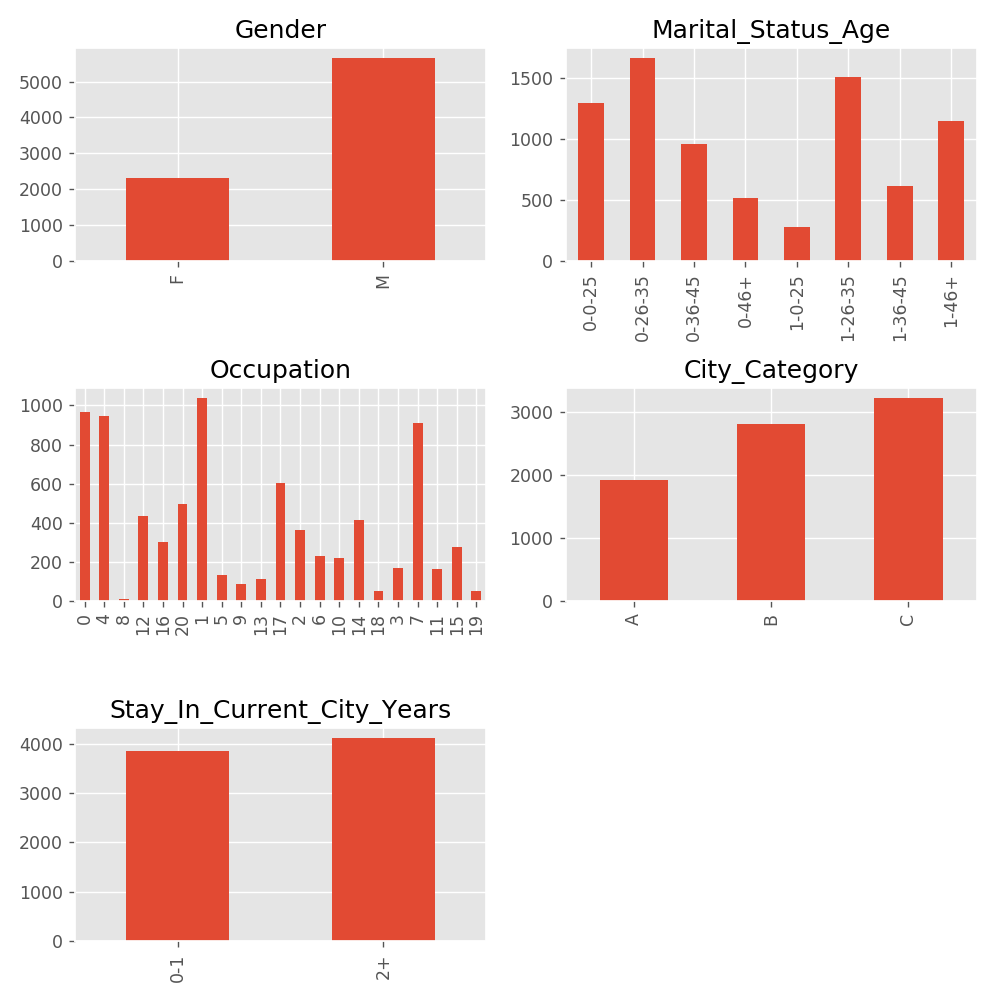

<IPython.core.display.Javascript object>


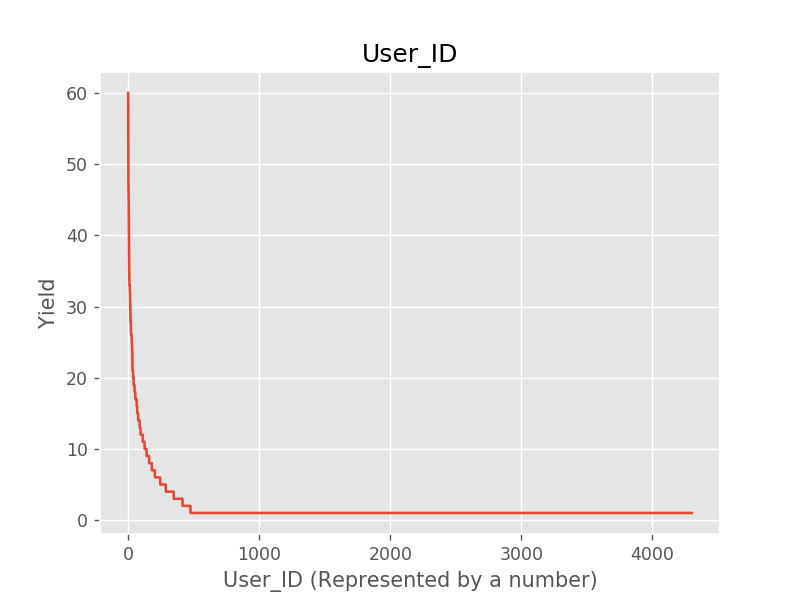

<IPython.core.display.Javascript object>


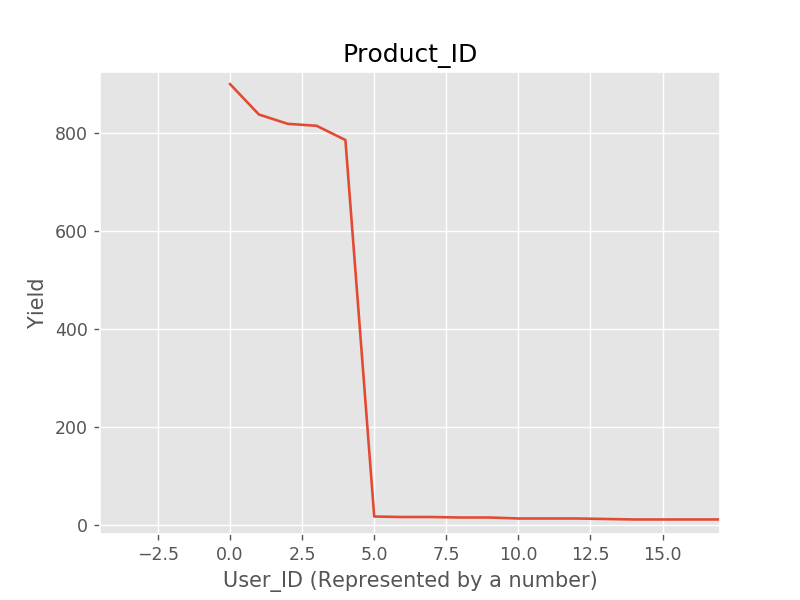

<IPython.core.display.Javascript object>


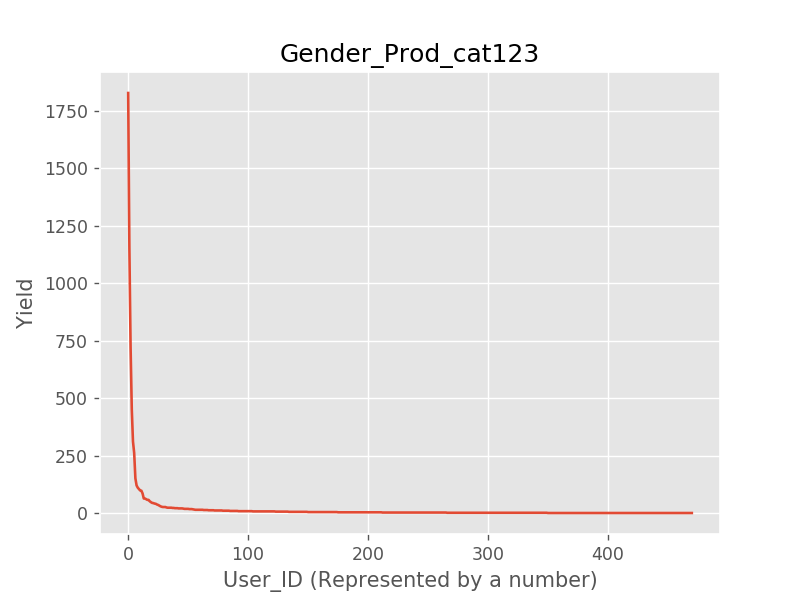

In [109]:
# Make plots for each features from worst subset
def plot_features(df_worst):
    # bar plot for the following list:
    cat_list = ['Gender', 'Marital_Status_Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years']

    _ , axw = plt.subplots(3, 2, figsize=(8,8))
    axw = axw.flatten()
    for k, colname in enumerate(cat_list):
        dis = df_worst.loc[:, colname]
        dis.value_counts(sort = False).plot(kind='bar', ax=axw[k])
        axw[k].set_title(dis.name)
    axw[-1].set_visible(False)
    plt.tight_layout()

    # UserID has too many users to show a bar plot, show line instead
    _ , axw2 = plt.subplots()
    # value_counts() sort value in descending order by default
    UserWorst_distrib = df_worst.User_ID.value_counts()
    # UserWorst_distrib.plot(kind='bar', ax=axw2)
    axw2.plot(range(UserWorst_distrib.count()) , UserWorst_distrib.values)
    axw2.set_title(UserWorst_distrib.name)
    axw2.set_xlabel(UserWorst_distrib.name + ' (Represented by a number)')
    axw2.set_ylabel('Yield')

    # There are too many Product ID to show a bar plot, show line instead
    _ , axw3 = plt.subplots()
    ProdIDWorst_distrib = df_worst.Product_ID.value_counts()
    # ProdIDWorst_distrib.plot(kind='bar', ax=axw3)
    axw3.plot(range(ProdIDWorst_distrib.count()) , ProdIDWorst_distrib.values)
    axw3.set_title(ProdIDWorst_distrib.name)
    axw3.set_xlabel(ProdIDWorst_distrib.name + ' (Represented by a number)')
    axw3.set_ylabel('Yield')

    _ , axw4 = plt.subplots()
    ProdCatWorst_distrib = df_worst.Gender_Prod_cat123.value_counts()
    # ProdCatWorst_distrib.plot(kind='bar', ax=axw4)
    axw4.plot(range(ProdCatWorst_distrib.count()) , ProdCatWorst_distrib.values)
    axw4.set_title(ProdCatWorst_distrib.name)
    axw4.set_xlabel(ProdCatWorst_distrib.name + ' (Represented by a number)')
    axw4.set_ylabel('Yield')

plot_features(df_worst)

There are very few product ID that shows large error multiple times

In [99]:
# number of product ID that have high error more than 16 times
ProdIDWorst_distrib[ProdIDWorst_distrib > 16].count()

6

In [115]:
# print those product ID
Bad_prodID = ProdIDWorst_distrib[ProdIDWorst_distrib > 16].index
print(Bad_prodID)

CategoricalIndex(['P00371644', 'P00372445', 'P00370853', 'P00375436',
                  'P00370293', 'P00057642'],
                 categories=['P00000142', 'P00000242', 'P00000342', 'P00000442', 'P00000542', 'P00000642', 'P00000742', 'P00000842', ...], ordered=False, dtype='category')


In [117]:
# Particularly bad Product ID
#df[df.Product_ID.isin(Bad_prodID) & (sqerr_asc > 5e7)]

#### Minimal error

In [112]:
# considering instance where error is relatively small
df_best = df.loc[sqerr_asc < 1000, :].copy()

# look at a few examples
df_best.describe(include='all')

,User_ID,Product_ID,Gender,Marital_Status_Age,Occupation,City_Category,Stay_In_Current_City_Years,Prod_cat123,Gender_Prod_cat123,Purchase
count,7.261000e+03,7261,7261,7261,7261.000000,7261,7261,7261,7261,7261.000000
unique,NaN,2052,2,8,NaN,3,2,219,383,NaN
top,NaN,P00112142,M,0-26-35,NaN,B,2+,5-nan-nan,1-191,NaN
freq,NaN,30,5598,1676,NaN,2693,3942,908,719,NaN
mean,1.000589e+06,NaN,NaN,NaN,8.326952,NaN,NaN,NaN,NaN,9228.035532
std,3.361761e+02,NaN,NaN,NaN,6.677393,NaN,NaN,NaN,NaN,4891.319952
min,1.000001e+06,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,186.000000
25%,1.000296e+06,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,5875.000000
50%,1.000588e+06,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,8040.000000
75%,1.000886e+06,NaN,NaN,NaN,14.000000,NaN,NaN,NaN,NaN,11970.000000


<IPython.core.display.Javascript object>


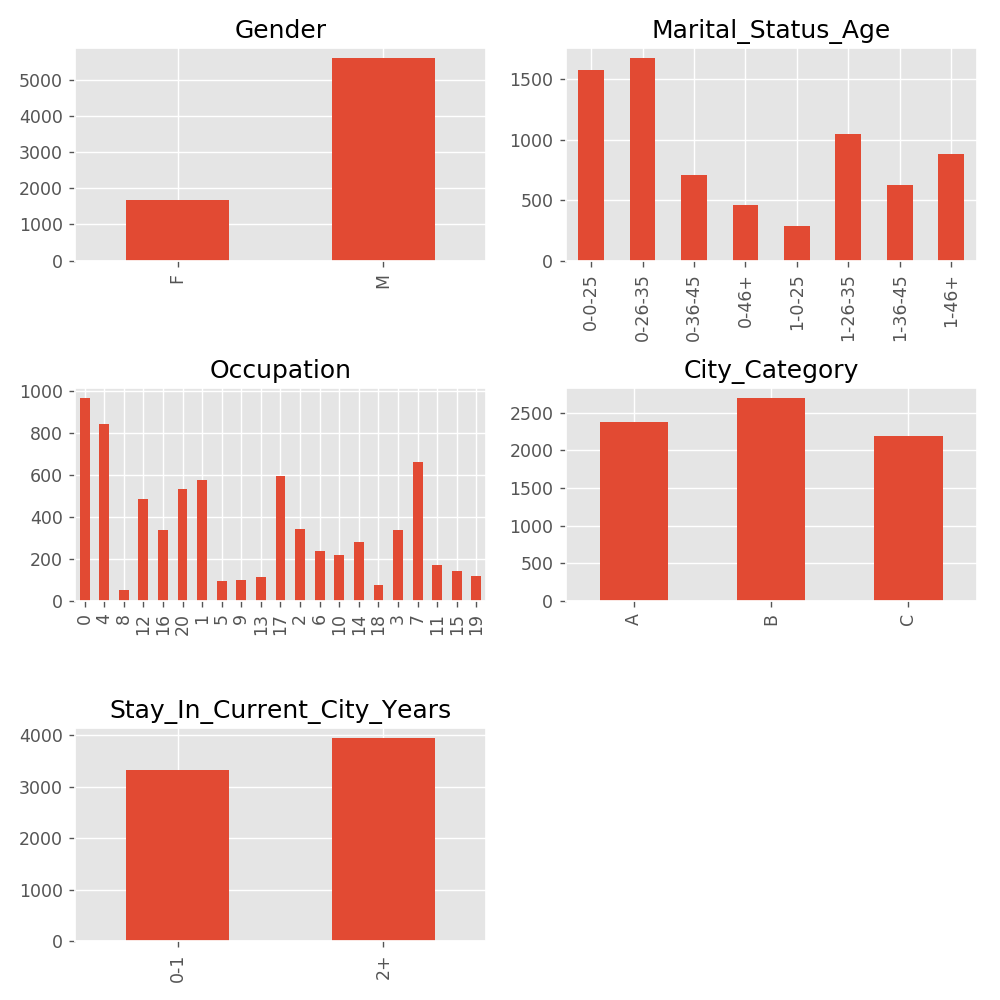

<IPython.core.display.Javascript object>


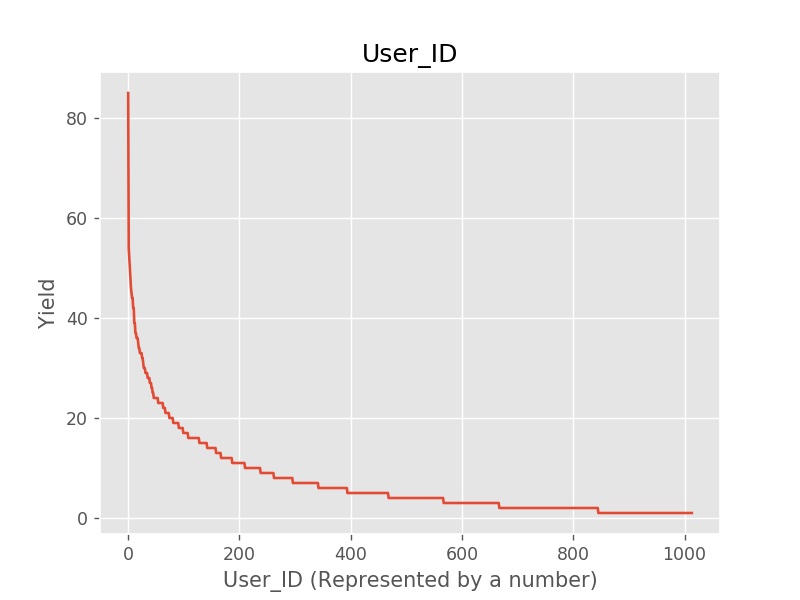

<IPython.core.display.Javascript object>


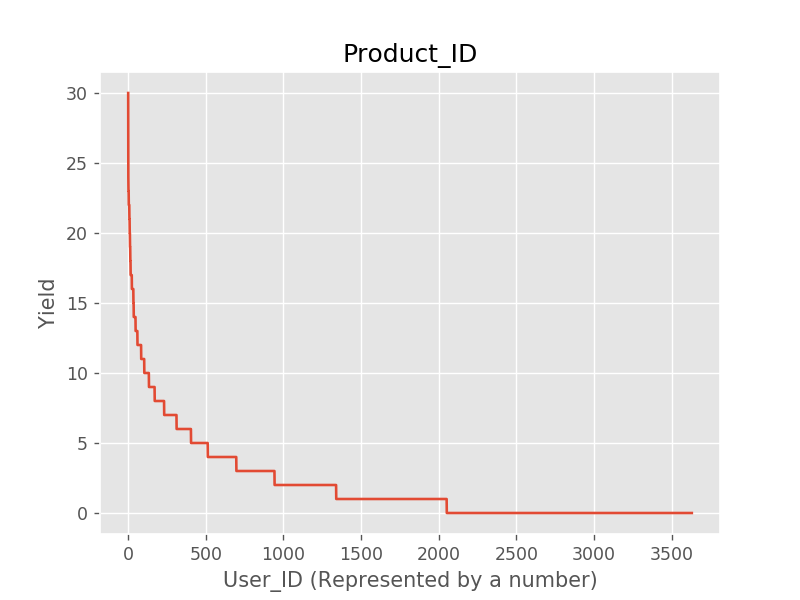

<IPython.core.display.Javascript object>


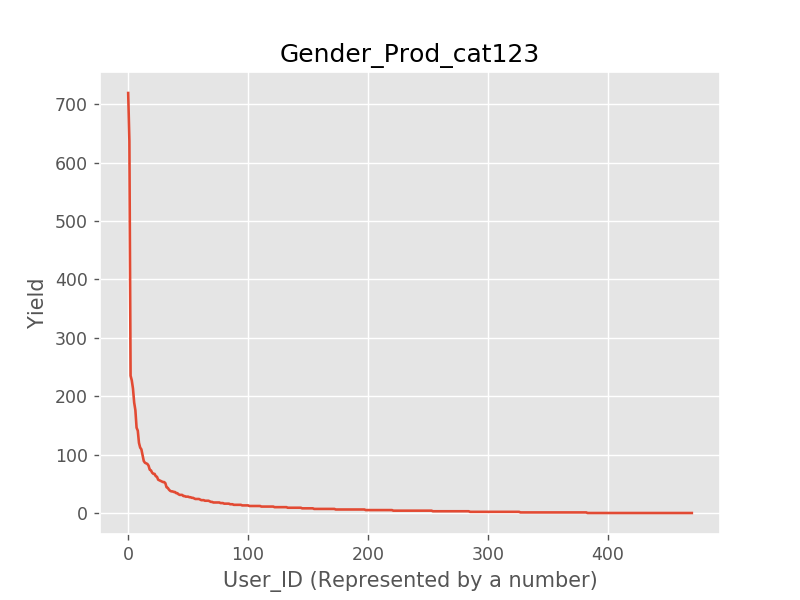

In [114]:
plot_features(df_best)

There isn't any obvious conclusion from our best cases.

# Linear Regression (remove worst prediction instances)
Here we wil explore the effect of considering worst cases as outliers and therefore removing them from our training set.

Create another model

In [ ]:
# create another model
model_outliers = LinearRegression(n_jobs=-1, normalize=False, fit_intercept=True)
# filter out worst prediction
X2 = X[df_worst.index.tolist(), :]
y2 = y[df_worst.index.tolist()]

Run cross-validation

In [ ]:
# report score on cross-validation
from sklearn.model_selection import cross_validate, ShuffleSplit
# n_splits is the number of times you split data after shuffling
cv = ShuffleSplit(n_splits=5, test_size=1/5, random_state=4)
# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
cv_results_linear2 = cross_validate(model_outliers, X2, y=y2, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

print('MSE (mean cross-validation) = {:.4f}'.format(-np.mean(cv_results_linear2['test_score'])))
print('RMSE (mean cross-validation) = {:.4f}'.format(np.sqrt(-np.mean(cv_results_linear2['test_score']))))

Rerun on entire training set

In [ ]:
model_outliers.fit(X2, y2)
y_pred2 = model_outliers.predict(X2)
from sklearn.metrics import mean_squared_error
print('MSE (whole training set) = {:.4f}'.format(mean_squared_error(y2, y_pred2)))
print('RMSE (whole training set) = {:.4f}'.format(np.sqrt(mean_squared_error(y2, y_pred2))))

# Extra: Linear Regression using SGD
Just as out curiosity.<br>
SGD: Stochastic Gradient Descent<br>
Just to try it out. Only faster than closed-form linear regression when n_samples and n_features are large. May not reach the absolute global minima (as opposed to closed-form obviously). Can also avoid local minima for non-convex cost function.

In [ ]:
from sklearn.linear_model import SGDRegressor
model_SGD = SGDRegressor(max_iter=50, penalty=None, eta0=0.1, tol=1e-3, shuffle=True)
model_SGD.fit(X, y)
y_predSGD = model_SGD.predict(X)
from sklearn.metrics import mean_squared_error
print('MSE = {:.4f}'.format(mean_squared_error(y, y_predSGD)))
print('RMSE = {:.4f}'.format(np.sqrt(mean_squared_error(y, y_predSGD))))

In [ ]:
model_SGD.n_iter_